## AutoML-fedot-API-exampleサンプルコード

In [1]:
%load_ext lab_black

In [2]:
# ライブラリーのインポート
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# ボストンの住宅価格データ
from sklearn.datasets import load_boston

# 前処理
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# fedot
import fedot
from fedot.api.main import Fedot

# 評価指標
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
# データセットの読込み
boston = load_boston()

# 説明変数の格納
df = pd.DataFrame(boston.data, columns=boston.feature_names)
# 目的変数の追加
df["MEDV"] = boston.target

# データの中身を確認
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
# ランダムシード値
RANDOM_STATE = 10

# 学習データと評価データの割合
TEST_SIZE = 0.2

# 学習データと評価データを作成
x_train, x_test, y_train, y_test = train_test_split(
    df.iloc[:, 0 : df.shape[1] - 1],
    df.iloc[:, df.shape[1] - 1],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train = pd.merge(x_train, y_train, left_index=True, right_index=True)
test = pd.merge(x_test, y_test, left_index=True, right_index=True)

In [5]:
auto_model = Fedot(
    problem="regression", timeout=None, seed=RANDOM_STATE, verbose_level=4
)
pipeline = auto_model.fit(features=train, target="MEDV")

Composition started. Parameters tuning: True. Set of candidate models: ['adareg', 'catboostreg', 'dtreg', 'gbr', 'knnreg', 'lasso', 'lgbmreg', 'linear', 'rfr', 'ridge', 'sgdr', 'svr', 'treg', 'xgbreg', 'scaling', 'normalization', 'pca', 'poly_features', 'one_hot_encoding', 'ransac_lin_reg', 'ransac_non_lin_reg', 'rfe_lin_reg', 'rfe_non_lin_reg']. Composing time limit: 2 min
Pipeline composition started
KFolds cross validation for pipeline composing was applied.
pop size: 21, num of new inds: 13
Pipeline ((/n_simple_imputation_default_params;)/n_scaling_default_params;)/n_xgbreg_{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 1.0, 'subsample': 0.15000000000000002, 'min_child_weight': 6, 'objective': 'reg:squarederror'} fit for cross validation started
Fit pipeline from scratch
Fit pipeline from scratch
Fit pipeline from scratch
Pipeline ((/n_simple_imputation_default_params;)/n_scaling_default_params;)/n_xgbreg_{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 1.0, 'subsampl

In [6]:
pipeline.print_structure()

Pipeline structure:
{'depth': 6, 'length': 7, 'nodes': [knnreg, linear, pca, xgbreg, scaling, poly_features, scaling]}
knnreg - {'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}
linear - default_params
pca - {'n_components': 0.9631490771645308, 'svd_solver': 'full'}
xgbreg - {'learning_rate': 0.5, 'max_depth': 7, 'min_child_weight': 20, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
scaling - default_params
poly_features - {'degree': 4, 'interaction_only': False}
scaling - default_params


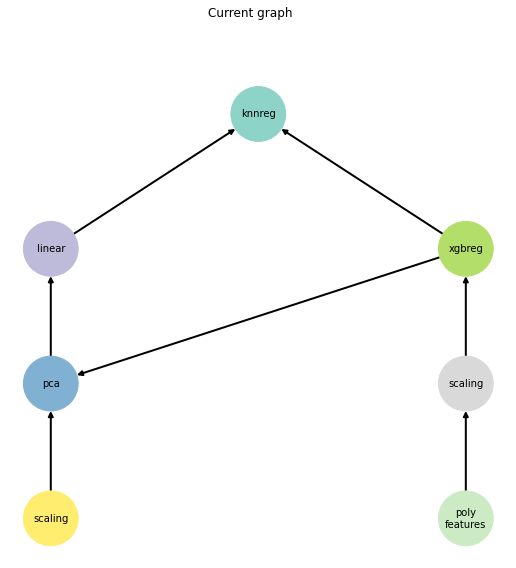

In [7]:
pipeline.show()

In [8]:
# 推論
y_pred = auto_model.predict(features=test)
auto_metrics = auto_model.get_metrics()
print(auto_metrics)

{'rmse': 3.6092835419615494, 'mae': 2.848941176470588}


In [9]:
# 評価
def calculate_scores(true, pred):
    """全ての評価指標を計算する

    Parameters
    ----------
    true (np.array)       : 実測値
    pred (np.array)       : 予測値

    Returns
    -------
    scores (pd.DataFrame) : 各評価指標を纏めた結果

    """
    scores = {}
    scores = pd.DataFrame(
        {
            "R2": r2_score(true, pred),
            "MAE": mean_absolute_error(true, pred),
            "MSE": mean_squared_error(true, pred),
            "RMSE": np.sqrt(mean_squared_error(true, pred)),
        },
        index=["scores"],
    )
    return scores

In [10]:
scores = calculate_scores(y_test, y_pred)
print(scores)

              R2       MAE        MSE      RMSE
scores  0.875437  2.848941  13.026928  3.609284
